# ITI distributions

In [2]:
""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
import seaborn as sns
from collections import defaultdict
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from scipy import stats

# --Machine learning and statistics+
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer

from one.api import ONE
import matplotlib.pyplot as plt

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Functions/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from plotting_functions import bins_per_trial_phase

one = ONE(base_url='https://alyx.internationalbrainlab.org')

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Parameters

In [4]:
bin_size = 0.1

data_path_v1 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v1/' + str(bin_size) + '/'
data_path_v2 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'
# data_path_v2 =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'

data_path = data_path_v2

os.chdir(data_path)
design_matrices = os.listdir(data_path)

if data_path == data_path_v1:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed_X', 'nose_speed_Y', 
              'l_paw_speed_X', 'l_paw_speed_Y', 'pupil_speed_X',
              'pupil_speed_Y', 'Gaussian_licks']
elif data_path == data_path_v2:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed', 'l_paw_speed', 'left_X', 'left_Y',
              'pupil_speed', 'pupil_X', 'pupil_Y', 'Lick count']

# Plotting params
multiplier = 1/bin_size

event_type_list = ['goCueTrigger_times']  # , 'feedback_times', 'firstMovement_times'
event_type_name = ['Go cue']  # , 'Feedback time', 'First movement onset'

List design matrices' eids

In [5]:
# Save data of all sessions for latter
idxs = []
mouse_names = []
for m, mat in enumerate(design_matrices):
    
    mouse_name = design_matrices[m][51:-4]
    eid = design_matrices[m][14:50]
    idx = str(eid + '_' + mouse_name)
    if m == 0:
        idxs = idx
        mouse_names = mouse_name
    else:
        idxs = np.hstack((idxs, idx))
        mouse_names = np.hstack((mouse_names, mouse_name))

In [6]:
# Save data of all sessions for latter
matrix_all = defaultdict(list)
matrix_all_unnorm = defaultdict(list)
session_all = defaultdict(list)

for m, mat in enumerate(idxs):
    if len(mat) > 35: 
            
        # Trials data
        session = idxs[m][0:36]
        session_trials = one.load_object(session, obj='trials', namespace='ibl')
        session_trials = session_trials.to_df()
        session_end = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
        session_start = list(session_trials['stimOn_times'])[0]

        # Get time of last unbiased trial
        unbiased = session_trials.loc[session_trials['probabilityLeft']==0.5]
        time_trial_90 = list(unbiased['stimOff_times'])[-1]
        
        filename = str('design_matrix_' + mat + '_'  + str(bin_size))  # + mouse_name + '_'
        big_design_matrix = pickle.load(open(filename, "rb"))
        design_matrix = big_design_matrix.groupby('Bin')[var_names].mean()  # 
        design_matrix = design_matrix.reset_index(level = [0])  # , 'Onset times'
        design_matrix = design_matrix.dropna()
    
        # Keep only first 90 trials
        design_matrix = design_matrix.loc[(design_matrix['Bin'] < time_trial_90 * 10) & (design_matrix['Bin'] > session_start * 10)]
        unbiased_trials = session_trials.loc[session_trials['stimOff_times'] < time_trial_90]
        training_set = np.array(design_matrix[var_names]).copy() 
        
        if len(training_set) > 0:
            # Standardization using StandardScaler
            scaler = StandardScaler()
            standardized = scaler.fit_transform(training_set)
            # Normalize between 0 and 1
            normalizer = Normalizer().fit(standardized)
            normalized = normalizer.transform(standardized)
        else:
            print(session)

        # Save results per mouse
        mouse_name = idxs[m][37:]
        matrix_all[mouse_name] = {}
        session_all[mouse_name] = {}
        matrix_all_unnorm[mouse_name] = {}

        matrix_all[mouse_name][session] = normalized
        session_all[mouse_name][session] = unbiased_trials    
        matrix_all_unnorm[mouse_name][session] = design_matrix
    
    else:
        print(mat)
            

local md5 mismatch on dataset: churchlandlab/Subjects/CSHL049/2020-01-11/001/alf/_ibl_trials.stimOff_times.npy
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab/Subjects/CSHL049/2020-01-11/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 4.60k/4.60k [00:00<00:00, 14.0kB/s]
local md5 mismatch on dataset: cortexlab/Subjects/KS023/2019-12-10/001/alf/_ibl_trials.goCueTrigger_times.npy
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS023/2019-12-10/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 5.26k/5.26k [00:00<00:00, 16.0kB/s]


_
poch_DY_013.png_


local md5 mismatch on dataset: cortexlab/Subjects/KS023/2019-12-08/001/alf/_ibl_trials.goCueTrigger_times.npy
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS023/2019-12-08/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 6.53k/6.53k [00:00<00:00, 18.6kB/s]
local md5 mismatch on dataset: cortexlab/Subjects/KS023/2019-12-06/001/alf/_ibl_trials.goCueTrigger_times.npy
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS023/2019-12-06/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 5.35k/5.35k [00:00<00:00, 15.4kB/s]
local md5 mismatch on dataset: cortexlab/Subjects/KS014/2019-12-03/001/alf/_ibl_trials.goCueTrigger_times.npy
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS014/2019-12-03/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 4.38k/4.38k [00:00<00:00, 13.5kB/s]


lls_
_
poch_CSHL060.png_
_matrix_


local md5 mismatch on dataset: cortexlab/Subjects/KS014/2019-12-07/001/alf/_ibl_trials.goCueTrigger_times.npy
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS014/2019-12-07/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 5.38k/5.38k [00:00<00:00, 14.9kB/s]


1b61b7f2-a599-4e40-abd6-3e758d2c9e25
_


In [ ]:
ITI = session_trials['goCueTrigger_times'] - session_trials['stimOff_times']
feedback = session_trials['stimOff_times'] - session_trials['feedback_times']
quiescence = session_trials['stimOn_times'] - session_trials['intervals_0']

In [8]:
session_trials.keys()

Index(['intervals_bpod_0', 'intervals_bpod_1', 'quiescencePeriod',
       'goCueTrigger_times', 'stimOff_times', 'goCue_times', 'feedbackType',
       'feedback_times', 'response_times', 'contrastLeft', 'rewardVolume',
       'stimOn_times', 'choice', 'contrastRight', 'firstMovement_times',
       'probabilityLeft', 'intervals_0', 'intervals_1'],
      dtype='object')

In [9]:
session_trials[['intervals_0', 'intervals_1']]

,intervals_0,intervals_1
0,9.009899,12.674898
1,13.047095,15.630203
2,15.995200,18.341628
3,18.700030,21.024731
4,21.376429,27.029859
...,...,...
404,3568.226542,3606.138200
405,3606.953302,3611.949533
406,3612.623335,3619.488247
407,3620.175046,3622.516173


In [11]:
session_trials['stimOn_times'] - session_trials['intervals_0']

0      1.970436
1      0.499783
2      0.529747
3      0.530247
4      0.553778
         ...   
404    0.873646
405    0.479352
406    0.481352
407    0.541079
408    0.767657
Length: 409, dtype: float64

In [7]:
session_trials

,intervals_bpod_0,intervals_bpod_1,quiescencePeriod,goCueTrigger_times,stimOff_times,goCue_times,feedbackType,feedback_times,response_times,contrastLeft,rewardVolume,stimOn_times,choice,contrastRight,firstMovement_times,probabilityLeft,intervals_0,intervals_1
0,0.000000,3.665002,0.441705,10.894997,12.174849,10.895877,1.0,11.111989,11.111897,1.00,1.5,10.980335,1.0,NaN,11.016805,0.5,9.009899,12.674898
1,4.037200,6.620303,0.410087,13.546996,15.130120,13.547845,1.0,14.042296,14.042197,NaN,1.5,13.546879,-1.0,0.125,13.764805,0.5,13.047095,15.630203
2,6.985300,9.331702,0.446345,16.525106,17.841516,16.525781,1.0,16.765023,16.764909,0.25,1.5,16.524947,1.0,NaN,16.659805,0.5,15.995200,18.341628
3,9.690100,12.014802,0.467037,19.230430,20.524714,19.231077,1.0,19.460720,19.460630,NaN,1.5,19.230277,-1.0,1.000,19.328805,0.5,18.700030,21.024731
4,12.366500,18.019902,0.479629,21.930332,26.529847,21.931040,-1.0,24.460354,24.459344,0.00,0.0,21.930207,-1.0,NaN,22.146805,0.5,21.376429,27.029859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404,3559.202299,3597.113801,0.634060,3569.100345,3605.638133,3569.101121,1.0,3604.571873,3604.571791,0.00,1.5,3569.100188,1.0,NaN,3604.433805,0.8,3568.226542,3606.138200
405,3597.928900,3602.925101,0.406991,3607.432805,3611.449419,3607.433587,1.0,3610.389325,3610.389223,0.00,1.5,3607.432654,1.0,NaN,3610.143805,0.8,3606.953302,3611.949533
406,3603.598899,3610.463801,0.413579,3613.104836,3618.988232,3613.105520,1.0,3617.918139,3617.918043,0.00,1.5,3613.104687,1.0,NaN,3617.428805,0.8,3612.623335,3619.488247
407,3611.150599,3613.491701,0.474353,3620.716252,3622.016129,3620.717059,1.0,3620.945269,3620.945155,1.00,1.5,3620.716126,1.0,NaN,3620.848805,0.8,3620.175046,3622.516173


## Concatenate sessions of the same animal

In [ ]:
collapsed_matrices = defaultdict(list)
collapsed_unnorm = defaultdict(list)
collapsed_trials = defaultdict(list)

# Collapse multiple sessions per mouse
for mouse in np.unique(mouse_names):
    if len(np.where(mouse_names==mouse)[0]) > 1 and len(mouse) > 0:
        mouse_sessions = list(matrix_all[mouse].keys())
        for s, session in enumerate(mouse_sessions):
            collapsed_matrices[mouse] = np.vstack(matrix_all[mouse][session])
            collapsed_unnorm[mouse] = np.vstack(matrix_all_unnorm[mouse][session])
            collapsed_trials[mouse] = pd.concat(session_all[mouse], ignore_index=True)

In [ ]:
len(collapsed_matrices.keys())

38

Need to figure why less animals/sessions!!!!!!!!!!!!!!!

## Preprocess list of design matrices

- Each session is saved under the mouse name; concatenated with other sessions of the same mouse;
- Only data up to trial 90 is kept;
- Data is normalized and standardized

In [ ]:
# Save data of all sessions for latter
matrix_all = defaultdict(list)
matrix_all_unnorm = defaultdict(list)
session_all = defaultdict(list)

for mouse_name in mouse_names:
    for m, mat in enumerate(design_matrices):
        
        if (mouse_name in mat) & (len(mouse_name) > 0): 
            
            # Trials data
            session = design_matrices[m][14:50]
            session_trials = one.load_object(session, obj='trials', namespace='ibl')
            session_trials = session_trials.to_df()
            session_end = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
            session_start = list(session_trials['stimOn_times'])[0]

            # Get time of last unbiased trial
            unbiased = session_trials.loc[session_trials['probabilityLeft']==0.5]
            time_trial_90 = list(unbiased['stimOff_times'])[-1]
            
            big_design_matrix = pickle.load(open(mat, "rb"))
            design_matrix = big_design_matrix.groupby('Bin')[var_names].mean()  # 
            design_matrix = design_matrix.reset_index(level = [0])  # , 'Onset times'
            design_matrix = design_matrix.dropna()
        
            # Keep only first 90 trials
            design_matrix = design_matrix.loc[(design_matrix['Bin'] < time_trial_90 * 10) & (design_matrix['Bin'] > session_start * 10)]
            unbiased_trials = session_trials.loc[session_trials['stimOff_times'] < time_trial_90]
            training_set = np.array(design_matrix[var_names]).copy() 
            
            if len(training_set) > 0:
                # Standardization using StandardScaler
                scaler = StandardScaler()
                standardized = scaler.fit_transform(training_set)
                # Normalize between 0 and 1
                normalizer = Normalizer().fit(standardized)
                normalized = normalizer.transform(standardized)
            
            idx = str(mat + '_' + mouse_name)
            # Save results per mouse
            matrix_all[idx].append(normalized)
            session_all[idx].append(unbiased_trials)    
            matrix_all_unnorm[idx].append(design_matrix) 
            
# # Collapse multiple sessions per mouse
# for mouse in np.unique(mouse_names):
#     if len(np.where(mouse_names==mouse)[0]) > 1 and len(mouse) > 0:
#         matrix_all[mouse] = np.vstack(matrix_all[mouse])
#         matrix_all_unnorm[mouse] = np.vstack(matrix_all_unnorm[mouse])
#         session_all[mouse] = pd.concat(session_all[mouse], ignore_index=True)

local md5 mismatch on dataset: churchlandlab/Subjects/CSHL049/2020-01-11/001/alf/_ibl_trials.stimOff_times.npy
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab/Subjects/CSHL049/2020-01-11/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 4.60k/4.60k [00:00<00:00, 13.9kB/s]
local md5 mismatch on dataset: cortexlab/Subjects/KS023/2019-12-10/001/alf/_ibl_trials.goCueTrigger_times.npy
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS023/2019-12-10/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 5.26k/5.26k [00:00<00:00, 13.6kB/s]
local md5 mismatch on dataset: cortexlab/Subjects/KS023/2019-12-08/001/alf/_ibl_trials.goCueTrigger_times.npy
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS023/2019-12-08/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 6.53k/6.53k [00:00<00:00, 20.1kB/s]
local md5 mismatch on dataset: cortexlab/Subjects/KS023/2019-12-06/001/alf/_ibl_trials.goCueTrigger_t

ValueError: Invalid experiment ID

In [ ]:
def plot_features_per_epoch(use_data, hue, label, order, filename):
    
    bins_df = bins_per_trial_phase(use_data, session_trials)
    bins_df = bins_df.rename(columns={0: 'Bin'})
    new_df = use_data.merge(bins_df, on='Bin')
    # melted = pd.melt(new_df, id_vars=['Bin', label, 'Trial'], value_vars=np.array(new_df.keys()[1:-1]))

    # new_df['broader_label'] = new_df['label']
    # new_df.loc[new_df['broader_label']=='Stimulus right', 'broader_label'] = 'Pre-choice'
    # new_df.loc[new_df['broader_label']=='Stimulus left', 'broader_label'] = 'Pre-choice'
    # new_df.loc[new_df['broader_label']=='Quiescence', 'broader_label'] = 'Pre-choice'
    # new_df.loc[new_df['broader_label']=='Left choice', 'broader_label'] = 'Choice'
    # new_df.loc[new_df['broader_label']=='Right choice', 'broader_label'] = 'Choice'
    # new_df.loc[new_df['broader_label']=='Correct feedback', 'broader_label'] = 'Post-choice'
    # new_df.loc[new_df['broader_label']=='Incorrect feedback', 'broader_label'] = 'Post-choice'
    # new_df.loc[new_df['broader_label']=='ITI_correct', 'broader_label'] = 'Post-choice'
    # new_df.loc[new_df['broader_label']=='ITI_incorrect', 'broader_label'] = 'Post-choice'

    new_df['broader_label'] = new_df['label']
    new_df.loc[new_df['broader_label']=='Stimulus right', 'broader_label'] = 'Stimulus'
    new_df.loc[new_df['broader_label']=='Stimulus left', 'broader_label'] = 'Stimulus'
    new_df.loc[new_df['broader_label']=='Quiescence', 'broader_label'] = 'Quiescence'
    new_df.loc[new_df['broader_label']=='Left choice', 'broader_label'] = 'Choice'
    new_df.loc[new_df['broader_label']=='Right choice', 'broader_label'] = 'Choice'
    new_df.loc[new_df['broader_label']=='Correct feedback', 'broader_label'] = 'Feedback'
    new_df.loc[new_df['broader_label']=='Incorrect feedback', 'broader_label'] = 'Feedback'
    new_df.loc[new_df['broader_label']=='ITI_correct', 'broader_label'] = 'ITI'
    new_df.loc[new_df['broader_label']=='ITI_incorrect', 'broader_label'] = 'ITI'
    
    
    new_df['side'] = np.sign(new_df['signed_contrast'])

    " Plots "
    # Plot some variables
    first_vars = ['avg_wheel_vel',
    'pupil_diameter',
    'whisker_me',
    'nose_speed',
    'l_paw_speed',
    'pupil_speed',
    'Lick count']

    fig, ax = plt.subplots(nrows=len(first_vars) , ncols=1, sharex=False, sharey=False, figsize=[10, 20])
    plt.rc('font', size=12)

    for v, var in enumerate(first_vars):
        use_data = new_df[['Bin', label, var, 'correct', 'side', 'choice']]
        
        sns.barplot(y=var, x=label, data=use_data, hue=hue, ax=ax[v], ci=95, palette='plasma', order=order)
        ax[v].set_xlabel('Mean')
        ax[v].set_xticklabels(order, rotation=30)

    plt.tight_layout()
    plt.show()

    pos_vars = [ 'left_X',
    'left_Y',
    'pupil_X',
    'pupil_Y',]
    fig, ax = plt.subplots(nrows=2 , ncols=2, sharex=False, sharey=False, figsize=[14, 10])
    plt.rc('font', size=12)

    for v, var in enumerate(pos_vars):
        
        use_data = new_df[['Bin', label, var, 'correct', 'side', 'choice']]

        if var == 'left_X':
            axis = ax[0, 0]
        elif var == 'left_Y':
            axis = ax[0, 1]
        elif var == 'pupil_X':
            axis = ax[1, 0]
        elif var == 'pupil_Y':
            axis = ax[1, 1]
            
        sns.barplot(y=var, x=label, data=use_data, hue=hue, ax=axis, ci=95, palette='plasma', order=order)
        axis.set_xlabel('Mean')
        axis.set_xticklabels(order, rotation=30)
        
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

In [ ]:
def stats_features_per_epoch(use_data, hue, label):
    
    bins_df = bins_per_trial_phase(use_data, session_trials)
    bins_df = bins_df.rename(columns={0: 'Bin'})
    new_df = use_data.merge(bins_df, on='Bin')
    new_df['side'] = np.sign(new_df['signed_contrast'])
    new_df.loc[new_df['side']==0] = np.nan

    new_df['broader_label'] = new_df['label']
    new_df.loc[new_df['broader_label']=='Stimulus right', 'broader_label'] = 'Stimulus'
    new_df.loc[new_df['broader_label']=='Stimulus left', 'broader_label'] = 'Stimulus'
    new_df.loc[new_df['broader_label']=='Quiescence', 'broader_label'] = 'Quiescence'
    new_df.loc[new_df['broader_label']=='Left choice', 'broader_label'] = 'Choice'
    new_df.loc[new_df['broader_label']=='Right choice', 'broader_label'] = 'Choice'
    new_df.loc[new_df['broader_label']=='Correct feedback', 'broader_label'] = 'Feedback'
    new_df.loc[new_df['broader_label']=='Incorrect feedback', 'broader_label'] = 'Feedback'
    new_df.loc[new_df['broader_label']=='ITI_correct', 'broader_label'] = 'ITI'
    new_df.loc[new_df['broader_label']=='ITI_incorrect', 'broader_label'] = 'ITI'
    new_df = new_df.dropna()
    
    trial_epochs = new_df[label].unique()
    hues = new_df[hue].unique()
    vars = new_df.keys()[0:11]

    p_values = pd.DataFrame(columns=['var', 'epoch', 'significance'])
    for v, var in enumerate(vars):
        var_data = new_df[['Bin', label, var, hue]]
        
        for e, epoch in enumerate(trial_epochs):
            epoch_data = var_data.loc[var_data[label]==epoch]
            
            group_1 = epoch_data.loc[epoch_data[hue]==hues[0], var]
            group_2 = epoch_data.loc[epoch_data[hue]==hues[1], var]
            
            _, p_v = stats.ttest_ind(group_1, group_2)

            # Save results
            p_value = pd.DataFrame(columns=['var', 'epoch', 'significance'], index=range(1))
            p_value['var'] = var
            p_value['epoch'] = epoch
            if (np.nanmean(group_2) > np.nanmean(group_1)) and (p_v < 0.05):
                p_value['significance'] = 'Significantly higher'
            elif (np.nanmean(group_2) < np.nanmean(group_1)) and (p_v < 0.05):
                p_value['significance'] = 'Significantly smaller'
            elif p_v >= 0.05:
                p_value['significance'] = 'Non significant'
                
            # Append
            p_values = pd.concat([p_values, p_value], ignore_index=True)
    
    # Plot 
    if hue in ['choice', 'side']:
        hue_names = np.array(['left', 'right'])
        hue_numbers = np.array([-1.0, 1.0])
    elif hue == 'correct':
        hue_names = np.array(['correct', 'incorrect'])
        hue_numbers = np.array([1., 0.])
    sns.catplot(y='var', x='significance', hue='epoch', data=p_values, 
    order=['Non significant', 'Significantly higher', 'Significantly smaller'],
    height=5, aspect=2)

    plt.title(str('Modulation by ' + hue + ' ' + str(hue_names[np.where(hue_numbers==hues[1])]) + 
                ' - ' + str(hue_names[np.where(hue_numbers==hues[0])])))
    plt.show()
            
    return p_values   

In [ ]:
def stats_features_per_epoch_sess(mouse_names, session_all, matrix_all, matrix_all_unnorm, hue, label):
    
    p_values = pd.DataFrame(columns=['mouse', 'var', 'epoch', 'significance'])
    
    # Loop through mice
    for m, mouse_name in enumerate(np.unique(mouse_names)):
        if len(mouse_name) > 0:
            
            # Get mouse data
            session_trials = session_all[mouse_name]
            design_matrix = matrix_all[mouse_name]
            unnorm_mat = matrix_all_unnorm[mouse_name]  
            
            if len(np.shape(design_matrix)) != 2:
                design_matrix = design_matrix[0]
                session_trials = session_trials[0]
                unnorm_mat = matrix_all_unnorm[mouse_name][0]
            
            " Prepare design matrix "
            design_matrix_heading = pd.DataFrame(columns=var_names)
            design_matrix_heading[var_names] = design_matrix
            bins = unnorm_mat['Bin']
            design_matrix_heading['Bin'] = bins
            
            design_matrix_heading['Lick count'] = gaussian_filter1d(design_matrix_heading['Lick count'], sigma=1)  # TODO: how to decide on sigma here???
            #plt.hist(use_data['Lick count'])
            design_matrix_heading['avg_wheel_vel'] = np.abs(design_matrix_heading['avg_wheel_vel'])

            " Prepare data for plotting "
            bins_df = bins_per_trial_phase(design_matrix_heading, session_trials)
            bins_df = bins_df.rename(columns={0: 'Bin'})
            new_df = design_matrix_heading.merge(bins_df, on='Bin')
            new_df['side'] = np.sign(new_df['signed_contrast'])
            new_df.loc[new_df['side']==0] = np.nan

            new_df['broader_label'] = new_df['label']
            new_df.loc[new_df['broader_label']=='Stimulus right', 'broader_label'] = 'Stimulus'
            new_df.loc[new_df['broader_label']=='Stimulus left', 'broader_label'] = 'Stimulus'
            new_df.loc[new_df['broader_label']=='Quiescence', 'broader_label'] = 'Quiescence'
            new_df.loc[new_df['broader_label']=='Left choice', 'broader_label'] = 'Choice'
            new_df.loc[new_df['broader_label']=='Right choice', 'broader_label'] = 'Choice'
            new_df.loc[new_df['broader_label']=='Correct feedback', 'broader_label'] = 'Feedback'
            new_df.loc[new_df['broader_label']=='Incorrect feedback', 'broader_label'] = 'Feedback'
            new_df.loc[new_df['broader_label']=='ITI_correct', 'broader_label'] = 'ITI'
            new_df.loc[new_df['broader_label']=='ITI_incorrect', 'broader_label'] = 'ITI'
            new_df = new_df.dropna()
            
            trial_epochs = new_df[label].unique()
            hues = new_df[hue].unique()
            vars = new_df.keys()[0:11]

            for v, var in enumerate(vars):
                var_data = new_df[['Bin', label, var, hue]]
                
                for e, epoch in enumerate(trial_epochs):
                    epoch_data = var_data.loc[var_data[label]==epoch]
                    
                    group_1 = epoch_data.loc[epoch_data[hue]==hues[0], var]
                    group_2 = epoch_data.loc[epoch_data[hue]==hues[1], var]
                    
                    _, p_v = stats.ttest_ind(group_1, group_2)

                    # Save results
                    p_value = pd.DataFrame(columns=['mouse', 'var', 'epoch', 'significance'], index=range(1))
                    p_value['mouse'] = mouse_name
                    p_value['var'] = var
                    p_value['epoch'] = epoch
                    if (np.nanmean(group_2) > np.nanmean(group_1)) and (p_v < 0.05):
                        p_value['significance'] = 'Significantly higher'
                    elif (np.nanmean(group_2) < np.nanmean(group_1)) and (p_v < 0.05):
                        p_value['significance'] = 'Significantly smaller'
                    elif p_v >= 0.05:
                        p_value['significance'] = 'Non significant'
                        
                    # Append
                    p_values = pd.concat([p_values, p_value], ignore_index=True)
            
    return p_values 

/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:430: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

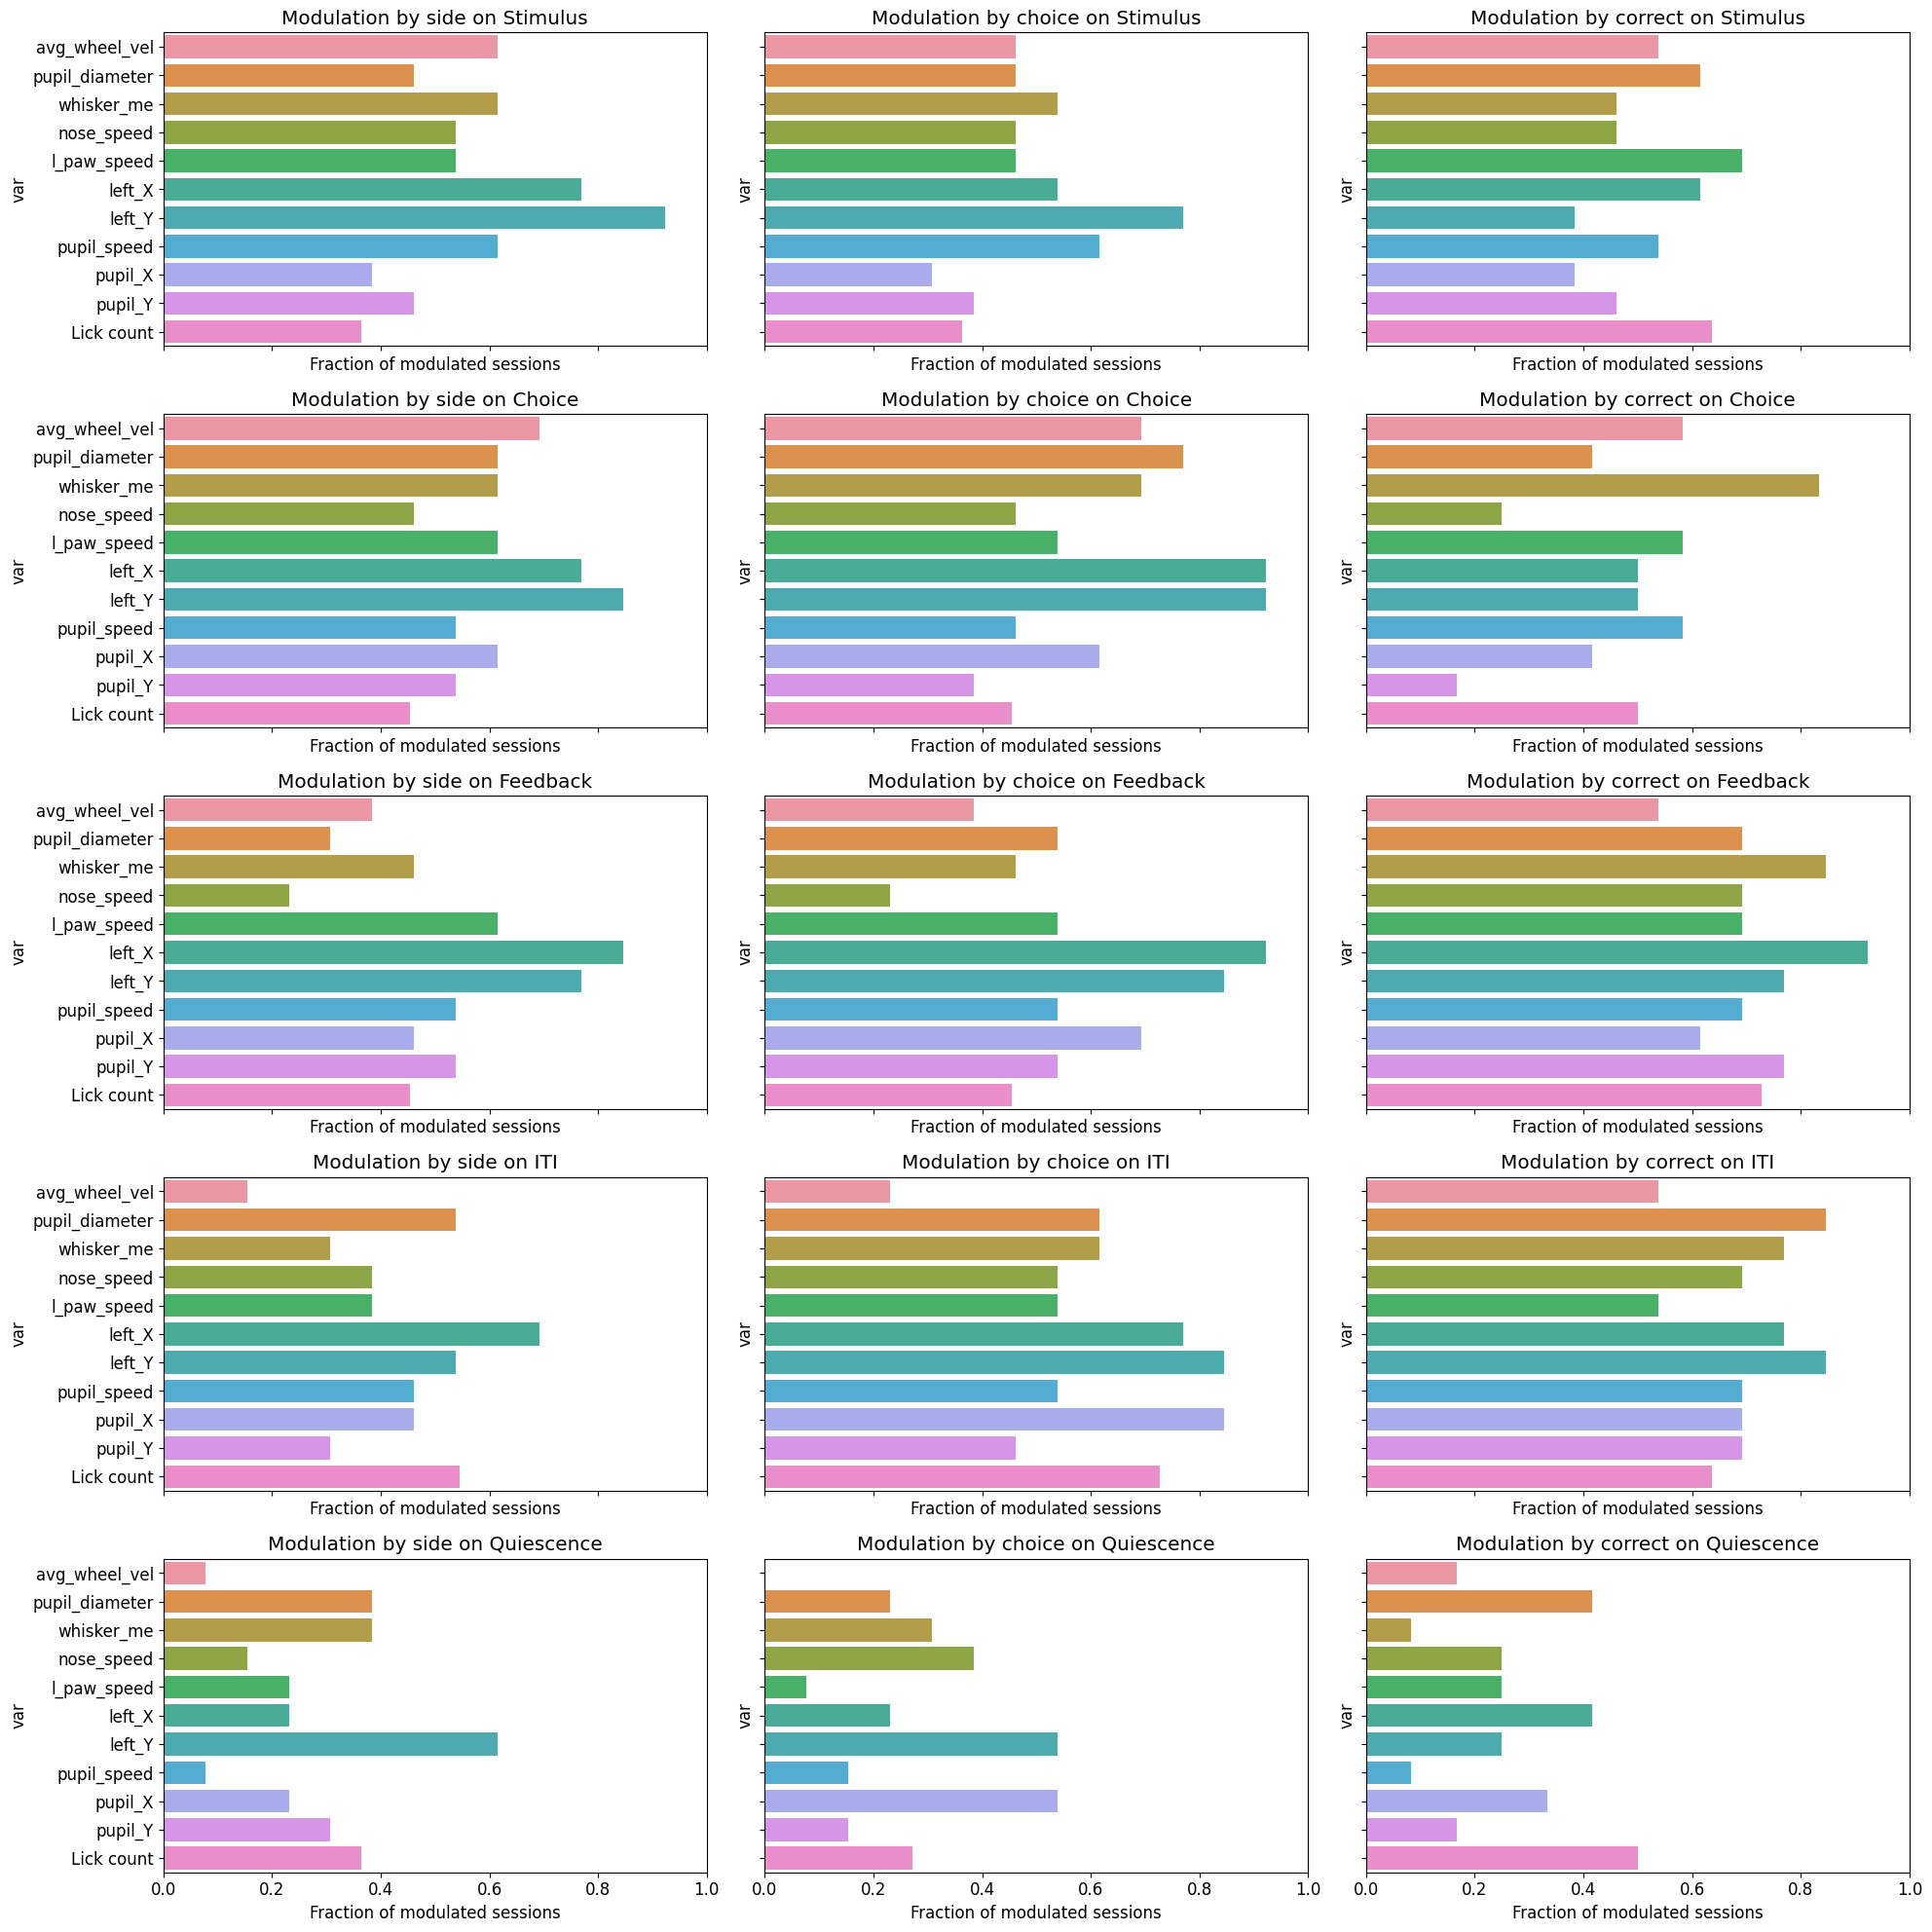

In [ ]:

# Plot 
hue_types = ['side', 'choice', 'correct']
fig, ax = plt.subplots(nrows=5 , ncols=len(hue_types), sharex=True, sharey=True, figsize=[20, 20])
for h, hue in enumerate(hue_types):
    if hue in ['choice', 'side']:
        hue_names = np.array(['left', 'right'])
        hue_numbers = np.array([-1.0, 1.0])
    elif hue == 'correct':
        hue_names = np.array(['correct', 'incorrect'])
        hue_numbers = np.array([1., 0.])

    p_values = stats_features_per_epoch_sess(mouse_names, session_all, matrix_all, matrix_all_unnorm, hue, label)

    trial_epochs = p_values['epoch'].unique()
    p_values.loc[p_values['significance']=='Significantly higher', 'significance'] = 1
    p_values.loc[p_values['significance']=='Significantly smaller', 'significance'] = 1
    p_values.loc[p_values['significance']=='Significantly higher', 'significance'] = 1
    p_values.loc[p_values['significance']=='Non significant', 'significance'] = 0
    for e, epoch in enumerate(trial_epochs):
        use_data = p_values.loc[p_values['epoch']==epoch]
        
        sns.barplot(y='var', x='significance', data=use_data, ax=ax[e, h], errorbar=None)  # order=['Non significant', 'Significant'],
        ax[e, h].set_xlabel('Fraction of modulated sessions')
        ax[e, h].set_title(str('Modulation by ' + hue + ' on ' + epoch))
        ax[e, h].set_xlim([0, 1])
plt.tight_layout()
plt.show()